# Xente fraud detection

## Content

1. Intro
2. Setup and import
3. Exploring and cleaning the data
4. Feature engineering
5. Modeling

## 1. Intro
Xente is a payment service.
In this notebook, we explore data of transactions.

**The goal is to build a model, that predicts wheter or not a transaction is fraudulent.**

Have a look on the website or this video to learn more.

Video: https://www.loom.com/share/95af830a57f5452085fe73e2f4edd414

Website: https://www.xente.co


## 2. Set-up and Import

In [49]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

###
# Import functions from own Python-File (see visuals_script.py in Repo)
import visuals_script as vs

# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# for neural network

import os

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers


import pathlib
import shutil
import tempfile


RSEED = 42
###

# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')


In [50]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [51]:
tf.keras.backend.set_floatx('float64')
plt.rcParams['figure.figsize'] = (15, 10)

## 3. Exploring and cleaning the data
The data is available on zindi: https://zindi.africa/competitions/xente-fraud-detection-challenge/data

In [52]:
df = pd.read_csv('data/training.csv')
df.columns = df.columns.str.lower()
#df.head()

In [53]:
# General information
# df.info()
# df.describe()
# df.nunique()


In [54]:
# Checking the target value
# sns.countplot(x=df.fraudresult)
# The data is highly imbalanced. 96000 non-frauds and 200 frauds.

In [55]:
# Currencycode and countrycode is the same for all transactions and contains no valuable information.
df.drop('currencycode', axis=1, inplace=True)
df.drop('countrycode', axis=1, inplace=True)

In [56]:
# Transforming the transaction start time into datetime
# The date is splitted into year, month, day, hour and weekday
# While doing this, we discussed a lot about the meaning of the date and time. Is the year or the second something, that contain information valuable for future fraud detection?
# Would you in practice try to keep as many of those variables as possible at first, then eventually throw them out after building your model?

df['transactionstarttime'] = df['transactionstarttime'].str.replace('T', ' ')
df['transactionstarttime'] = df['transactionstarttime'].str.replace('Z', '')
df['transactionstarttime'] = pd.to_datetime(df['transactionstarttime'], infer_datetime_format=True) 
df['year'] = df['transactionstarttime'].dt.year
df['month'] = df['transactionstarttime'].dt.month
df['day'] = df['transactionstarttime'].dt.day
df['hour'] = df['transactionstarttime'].dt.hour
df['weekday'] = df['transactionstarttime'].dt.weekday

df.drop('transactionstarttime', axis=1, inplace=True)


#### Trying to make sense of the ID columns

**transactionid:** Unique transaction identifier on platform

**batchid:** Unique number assigned to a batch of transactions for processing

**accountid:** Unique number identifying the customer on (xente) platform

**subscriptionid:** identifying the customer subscription

**customerid:** Unique identifier attached to Account

**providerid:** Identifying the provider of the product (for example phone company for airtime)

**productid:** Product being bought (23 different products)

**channelid:** Identifies if customer used web,Android, IOS, pay later or checkout.(4 categories)

**productcategory:** ProductIds are organized into these broader product categories. (9 categories)

In [57]:
# df['accountid'].value_counts()
# df['subscriptionid'].value_counts()
# df['customerid'].value_counts()
# df['providerid'].value_counts()
# df['channelid'].value_counts()
#df['productcategory'].value_counts()


In [58]:
# Cleaning the id columns
df["transactionid"] = df["transactionid"].apply(lambda x: x.replace("TransactionId_", ""))
df["batchid"] = df["batchid"].apply(lambda x: x.replace("BatchId_", ""))
df["accountid"] = df["accountid"].apply(lambda x: x.replace("AccountId_", ""))
df["customerid"] = df["customerid"].apply(lambda x: x.replace("CustomerId_", ""))
df["providerid"] = df["providerid"].apply(lambda x: x.replace("ProviderId_", ""))
df["productid"] = df["productid"].apply(lambda x: x.replace("ProductId_", ""))
df["channelid"] = df["channelid"].apply(lambda x: x.replace("ChannelId_", ""))
df["subscriptionid"] = df["subscriptionid"].apply(lambda x: x.replace("SubscriptionId_", ""))

**How to decide, whether or not to keep an ID? Does it make sense to drop unique IDs and keep categorical IDs?**

The batch_id for example is categorical, but has nearly 95000 unique values. 

Does it make sense to keep this and create dummies?

In [59]:
# We decided to drop most of the IDs
df = df.drop(['transactionid', 'batchid', 'accountid', 'subscriptionid', 'customerid'], axis=1)


In [60]:
df.head()

,providerid,productid,productcategory,channelid,amount,value,pricingstrategy,fraudresult,year,month,day,hour,weekday
0,6,10,airtime,3,1000.0,1000,2,0,2018,11,15,2,3
1,4,6,financial_services,2,-20.0,20,2,0,2018,11,15,2,3
2,6,1,airtime,3,500.0,500,2,0,2018,11,15,2,3
3,1,21,utility_bill,3,20000.0,21800,2,0,2018,11,15,3,3
4,4,6,financial_services,2,-644.0,644,2,0,2018,11,15,3,3


## 4. Feature Engineering

In [61]:
# The value and amount column contain nearly the same information. The only difference is, that the amount column shows, whether a transaction was a debit or a credit. 
# Therefor we decided to change the amount column, so it only shows this additional information.
df["debit"] = df["amount"].apply(lambda x: 0 if x > 0 else 1)
# df[["amount", "debit"]]
df.drop('amount', axis=1, inplace=True)

In [62]:
# df[df['fraudresult'] == 1].groupby('productcategory').count()
# df[df['fraudresult'] == 1].groupby('channelid').count()
# df[df['fraudresult'] == 1].groupby('productid').count()
# df[df['fraudresult'] == 1].groupby('value').count().sort_values('value',ascending=False).head(60)

### Creating dummies

In [63]:
X = df.drop('fraudresult', axis=1)
y = df.fraudresult

In [64]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = X
cat_feats = ['providerid', 'productid', 'productcategory', 'channelid', 'pricingstrategy', 'year', 'month', 'day', 'hour', 'weekday']
features_dummies = pd.get_dummies(features, columns=cat_feats, drop_first=True)

# TODO: Our Target is already a numerical value with 0 for ok and 1 for fraud
target_enc = y 

# features_dummies.head()
# features_dummies.shape
# features_dummies.info()
# X.info()

### Shuffle and Split Data

Now all _categorical variables_ have been converted into numerical features. We will now split the data (both features and their labels) into training and test sets. 70% of the data will be used for training and 30% for testing.  

In [65]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_dummies, target_enc, test_size=0.3, random_state=RSEED, stratify= target_enc)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 66963 samples.
Testing set has 28699 samples.


### Normalizing Numerical Features
Normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. To avoid data leakage we will normalize the data after we split it into train and test set. 

In [66]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
numerical = ['value']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical] = scaler.fit_transform(X_train_scaled[numerical])
X_test_scaled[numerical] = scaler.transform(X_test_scaled[numerical])

# Show an example of a record with scaling applied
# X_train_scaled.head()

### Synthetic minority oversampling

To deal with the imbalance, we decided to create new fraud instances using SMOTE. These will only be used to train our model.

In [67]:
# summarize class distribution
counter = Counter(y_train)
print(counter)


Counter({0: 66828, 1: 135})


In [68]:
# transform the dataset
# do all imports at the top
oversample = SMOTE()
X_train_sample, y_train_sample = oversample.fit_resample(X_train_scaled, y_train)


In [69]:
# summarize the new class distribution
counter = Counter(y_train_sample)
print(counter)

Counter({0: 66828, 1: 66828})


## 5. Modeling

### Baseline Model:
As a starting point, we create a simple baseline model. When exploring the data, we saw, that higher transaction values are more likely to be fraudulent.

Let's test a model, that predicts the following:

A transaction is always fraudulent, if the value is higher than 500.000 UGX

In [70]:
# Create prediction of our baseline model
y_pred_baseline = (X_test.value >= 500000)*1

# Testing it on the test data
print("Accuracy: ", accuracy_score(y_test, y_pred_baseline))
print("Recall: ", recall_score(y_test, y_pred_baseline))
print("Precision: ", precision_score(y_test, y_pred_baseline))
print("F1-score: ", f1_score(y_test, y_pred_baseline))
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred_baseline))

Accuracy:  0.9990243562493467
Recall:  0.8793103448275862
Precision:  0.7083333333333334
F1-score:  0.7846153846153847
Confusion matrix:
[[28620    21]
 [    7    51]]


## Neural Network Model

In [71]:
# Convert to np array
X_train_ann = X_train_scaled.values
X_test_ann = X_test_scaled.values
y_train_ann = y_train.values
y_test_ann = y_test.values

In [72]:
# Define dictionary to store results
training_history = {}

# Define number of epochs and learning rate decay
N_TRAIN = len(X_train)
EPOCHS = 500
BATCH_SIZE = 32
# Too much steps for this dataset
#STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#    0.01,
#    decay_steps=STEPS_PER_EPOCH*1000,
#    decay_rate=1,
#    staircase=False)


# Define optimizer used for modelling
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

In [73]:
# Plotting function for MSE
def plot_metric(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [74]:
# Plotting function for loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

### Small DNN Model

In [80]:
X_train_ann.shape

(66963, 106)

In [164]:
# Define model architecture in function
def get_compiled_small_model():
    small_model = tf.keras.Sequential([
      tf.keras.layers.Dense(20,kernel_initializer = 'uniform', activation='relu', input_dim = 106),
      tf.keras.layers.Dense(20,kernel_initializer = 'uniform', activation='relu'),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform', activation = 'sigmoid')# sigmoid necessary for classification
    ])
    
    small_model.compile(optimizer='sgd',
                  loss='mse',
                  metrics=[tf.keras.metrics.CategoricalCrossentropy()])
    return small_model


   #### Alternitive
    small_model.compile(optimizer='adam',
                  loss='binary_crossentropy',# necessary for classification
                  metrics=['accuracy'])
    return small_model

In [165]:
# Instantiate small model and print model summary
with tf.device('/cpu:0'):
    small_model = get_compiled_small_model()
    print(small_model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 20)                2140      
                                                                 
 dense_46 (Dense)            (None, 20)                420       
                                                                 
 dense_47 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________
None


In [166]:
# Run model
with tf.device('/cpu:0'):
    training_history['small'] = small_model.fit(X_train_ann,
                        y_train_ann,
                        validation_split=0.2,
                        verbose=0,
                        #steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS)

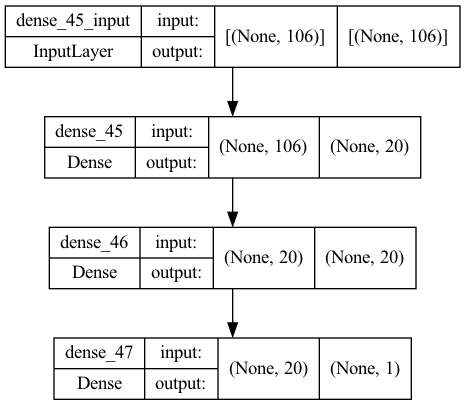

In [167]:
# Model picture
from tensorflow.keras.utils import plot_model
plot_model(
    small_model, to_file='model.png', show_shapes=True, 
    show_layer_names=True, dpi=96
)

2023-01-11 15:42:34.256471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


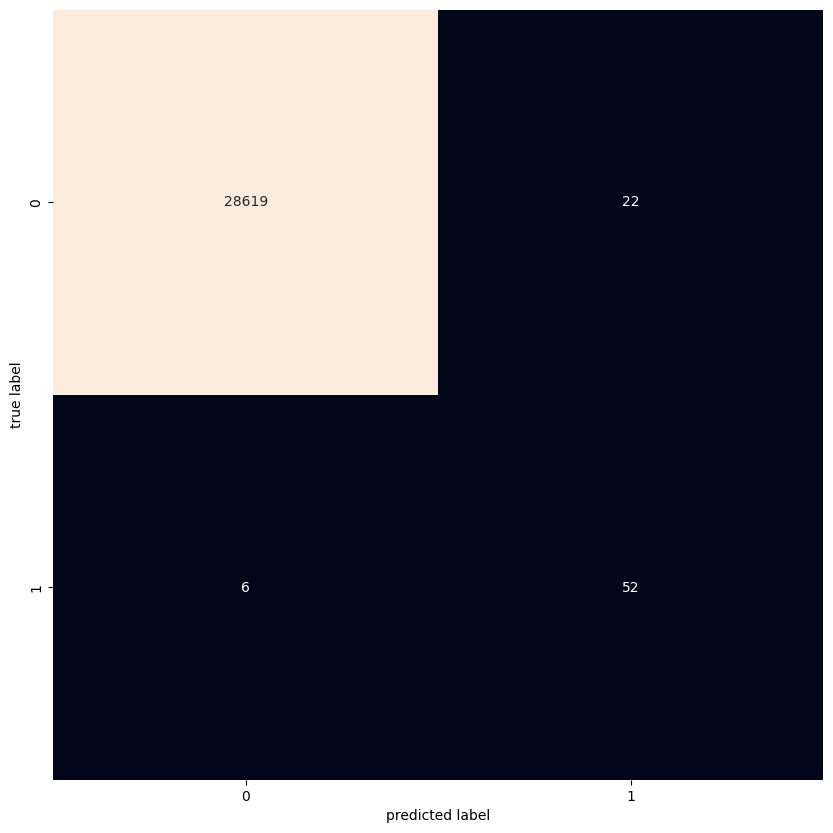

In [168]:
# Predicting and evaluating model
y_pred = small_model.predict(X_test_ann).round(0)

# Plotting the confusing matrix
mat = confusion_matrix(y_test_ann, y_pred.round(0))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [169]:
# Evaluation scores
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_ann, y_pred)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test_ann, y_pred)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_ann, y_pred, beta = 1)))
print(classification_report(y_test_ann, y_pred))
print("Confusion matrix baseline:")
print(confusion_matrix(y_test,y_pred_baseline))

Final accuracy score on the testing data: 0.9990
Final recall score on the testing data: 0.8966
Final F-score on the testing data: 0.7879
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.70      0.90      0.79        58

    accuracy                           1.00     28699
   macro avg       0.85      0.95      0.89     28699
weighted avg       1.00      1.00      1.00     28699

Confusion matrix baseline:
[[28620    21]
 [    7    51]]


In [ ]:
### Result optimized for accuracy with adam
#Final accuracy score on the testing data: 0.9995
#Final recall score on the testing data: 0.7931
#Final F-score on the testing data: 0.8598
#              precision    recall  f1-score   support
#
#           0       1.00      1.00      1.00     28641
#           1       0.94      0.79      0.86        58
#
#    accuracy                           1.00     28699
#   macro avg       0.97      0.90      0.93     28699
#weighted avg       1.00      1.00      1.00     28699

## Conclusion

By using the neural network model in the fraud prediction’s project, we can notice, that we didn’t improve the results. The F1-Score got worse by 7%. On the other hand there was big improvement of the recall by 11%. As we decided to use the F1_Score metric as a better and more realistic indicator, we don’t see any need of using the neural network in this Project. 

### Why does this next model not work?
### Model iteration with dropout

In [171]:
# Define model architecture in function
def get_compiled_l2_dropout_model():
    best_model = tf.keras.Sequential([
      tf.keras.layers.Dense(16,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01), input_dim = 106),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(16,kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1,kernel_initializer = 'uniform', activation = 'sigmoid')# sigmoid necessary for classification
    ])
    
    best_model.compile(optimizer='sgd',
                  loss='mse',
                  metrics=[tf.keras.metrics.CategoricalCrossentropy()])
    return best_model

In [172]:
# Instantiate small model and print model summary
with tf.device('/cpu:0'):
    best_model = get_compiled_l2_dropout_model()
    print(best_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 16)                1712      
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________
None


In [173]:
# Run model
with tf.device('/cpu:0'):
    training_history['best'] = best_model.fit(X_train_ann,
                        y_train_ann,
                        validation_split=0.2,
                        verbose=0,
                        epochs=EPOCHS)

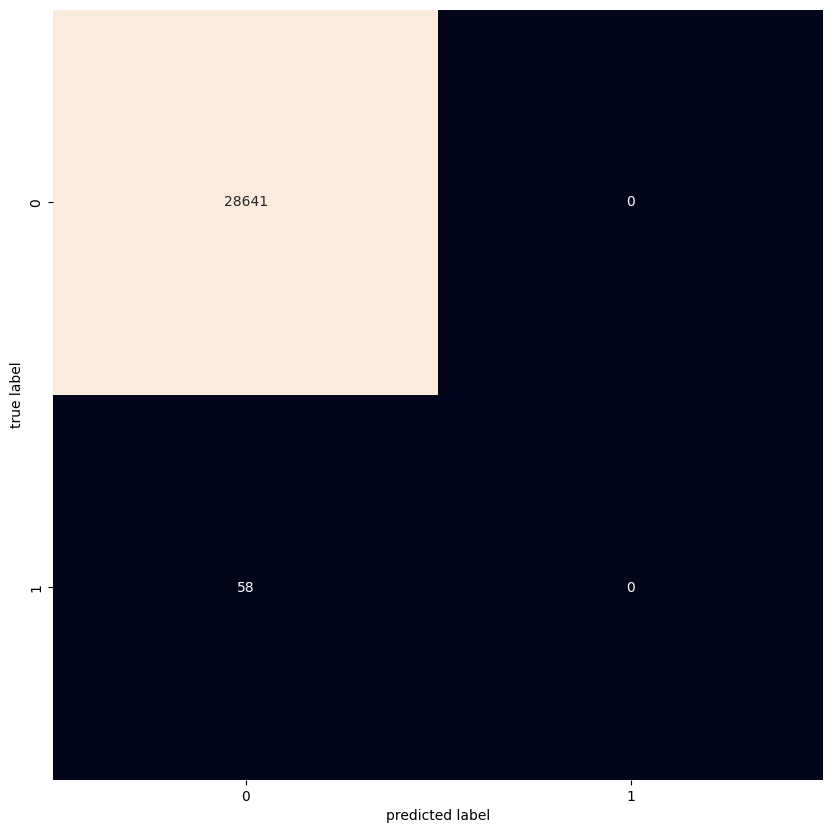

In [175]:
# Predicting and evaluating model
y_pred_best = best_model.predict(X_test_ann).round(0)

# Plotting the confusing matrix
mat = confusion_matrix(y_test_ann, y_pred_best)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [176]:
# Evaluation scores
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_ann, y_pred_best)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test_ann, y_pred_best)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_ann, y_pred_best, beta = 1)))
print(classification_report(y_test_ann, y_pred_best))
print("Confusion matrix baseline:")
print(confusion_matrix(y_test, y_pred_baseline))

Final accuracy score on the testing data: 0.9980
Final recall score on the testing data: 0.0000
Final F-score on the testing data: 0.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.00      0.00      0.00        58

    accuracy                           1.00     28699
   macro avg       0.50      0.50      0.50     28699
weighted avg       1.00      1.00      1.00     28699

Confusion matrix baseline:
[[28620    21]
 [    7    51]]
